<a href="https://colab.research.google.com/github/kelvinsima2/wildlife_images_classification/blob/main/Wildlife_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
# In this project, the images are in google drive.
# Start by connecting to google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Necessary Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from keras.preprocessing.image import ImageDataGenerator



# Image Preprocessing

In [ ]:
# Specify where the image folders are located
input_dir = '/content/drive/My Drive/Wildlife Project/animals/'

In [ ]:
# display first 10 image classes
parent_list = os.listdir(input_dir)
for i in range(10):
    print(parent_list[i])

bee
beetle
bear
cat
badger
bison
antelope
butterfly
bat
boar


In [ ]:
# Display number of classes
len(parent_list)

90

In [ ]:
# Specify image size and batch size
SIZE = 256
BATCH_SIZE = 32


In [ ]:
# Split images into training and validation sets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=input_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="training",
                                             seed=0,
                                             label_mode = 'categorical');

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=input_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="validation",
                                             seed=0,
                                             label_mode = 'categorical');

Found 5400 files belonging to 90 classes.
Using 4320 files for training.
Found 5400 files belonging to 90 classes.
Using 1080 files for validation.


In [ ]:
# Obtain class names from training data. It is worth noting that they are presented in alphabetical order. This is useful during model testing.
class_names = train_dataset.class_names

In [ ]:
# Display shape of training set
train_dataset.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 90), dtype=tf.float32, name=None))

In [ ]:
# Obtain test data from validation data
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 28
Number of test batches: 6


In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking. This improves performance.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Model Development and Evaluation

In [ ]:
# Apply random transformations such as flipping and rotation to images through data augmentation.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# Use the resnet_v2 preprocessing function to rescale pixel values
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [ ]:
# Specify image size and shape
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)

# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=IMG_SHAPE
                     )
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
base_model.trainable=False

# Create Tensorflow functional model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.BatchNormalization(renorm=True)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
#x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
# The output layer has 90 outputs representing the number of classes in the image dataset.
outputs = tf.keras.layers.Dense(90, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
 

In [ ]:
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
# Get model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                           

In [ ]:
# early stopping call back
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)


In [ ]:
# Train model using GPU
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks = [early])

Epoch 1/10


135/135 [==============================] - 64s 381ms/step - loss: 2.1145 - accuracy: 0.5498 - val_loss: 0.5539 - val_accuracy: 0.8468
Epoch 2/10
135/135 [==============================] - 49s 355ms/step - loss: 0.7745 - accuracy: 0.7873 - val_loss: 0.4276 - val_accuracy: 0.8705
Epoch 3/10
135/135 [==============================] - 49s 356ms/step - loss: 0.5936 - accuracy: 0.8329 - val_loss: 0.3819 - val_accuracy: 0.8863
Epoch 4/10
135/135 [==============================] - 49s 354ms/step - loss: 0.4977 - accuracy: 0.8583 - val_loss: 0.3471 - val_accuracy: 0.8941
Epoch 5/10
135/135 [==============================] - 48s 353ms/step - loss: 0.4299 - accuracy: 0.8694 - val_loss: 0.3292 - val_accuracy: 0.9088
Epoch 6/10
135/135 [==============================] - 48s 352ms/step - loss: 0.3897 - accuracy: 0.8833 - val_loss: 0.3354 - val_accuracy: 0.9054
Epoch 7/10
135/135 [==============================] - 48s 351ms/step - loss: 0.3491 - accuracy: 0.8905 - val_loss: 0.3465 - val_accuracy: 0.9

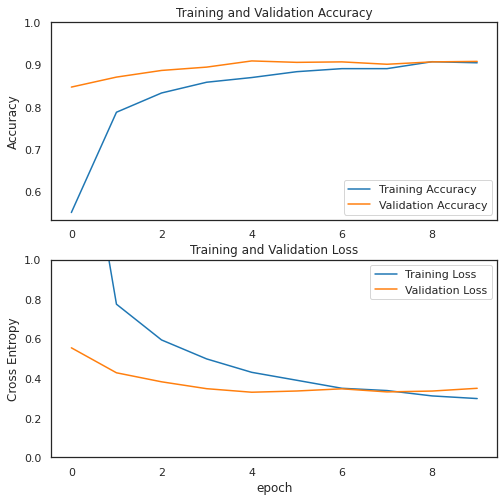

In [ ]:
# Plot accuracy and loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_dataset)

6/6 [==============================] - 2s 221ms/step - loss: 0.3823 - accuracy: 0.9062


# Test Model on Images from the Internet

In [ ]:
# A Python module to get random images/facts of different animals
pip install animals.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


https://i.some-random-api.ml/JfTtZzPgc7.jpg
1/1 [==============================] - 3s 3s/step
This image most likely belongs to kangaroo.


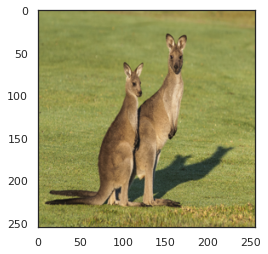

In [ ]:
import cv2
from PIL import Image
import requests
from animals import Animals

animal = Animals('kangaroo')
print(animal.image()) # Prints the url for the image

koala_url = animal.image()

img = Image.open(requests.get(koala_url, stream=True).raw)
img_resized = img.resize((256,256))
plt.imshow(img_resized)
img_array = tf.keras.utils.img_to_array(img_resized)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)